In [ ]:
import os
import json
import math
import numpy as np
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

import random


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

<ipython-input-1-40ed17b747df>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_transform = transforms.Compose(
    [transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder(root ="drive/MyDrive/trafic_32", transform=train_transform)

loader = data.DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)

def get_train_images(num):
    return torch.stack([dataset[random.randint(0, 20000)][0] for i in range(10,10+num)], dim=0)

NameError: name 'dataset' is not defined

In [ ]:
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        for i in range(num_channels):
            mean[i] += images[:,i,:,:].mean()
            std[i] += images[:,i,:,:].std()
    mean.div_(len(loader))
    std.div_(len(loader))
    print(mean, std)

    return mean, std

mean, std = get_mean_std(loader)

NameError: name 'loader' is not defined

In [ ]:
normalize_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std)])

torch.manual_seed(42)
number_of_train_examples = int(len(dataset) * 0.9)
number_of_val_examples = len(dataset) - number_of_train_examples
train_indices, val_indices = data.random_split(
    range(len(dataset)), [number_of_train_examples, number_of_val_examples]
)

train_dataset = data.Subset(dataset, train_indices)
val_dataset = data.Subset(dataset, val_indices)

train_dataset.dataset.transform = normalize_transform
val_dataset.dataset.transform = normalize_transform

train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True, pin_memory=True)

def denormalize(img):
    for channel in range(3):
        img[channel] = (img[channel] * std[channel]) + mean[channel]
    return img

In [ ]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()
    generate_images = [denormalize(img) for img in generated_imgs]

    grid = torchvision.utils.make_grid(generated_imgs, nrow=8, normalize=False)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False)
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

# VAE

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.conv2 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.fc_1 = nn.Linear(128*8*8, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = F.leaky_relu(self.conv2(x) )
        x = F.leaky_relu(self.conv3(x) )
        x = F.leaky_relu(self.conv4(x) )
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.conv2 = nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=3, output_padding=1, padding=1, stride=2)
        self.conv3 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, output_padding=0, padding=2, stride=1)
        self.conv4 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, output_padding=1, padding=1, stride=2)
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, 128*8*8)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 128, 8, 8])
        x_hat = F.leaky_relu(self.conv2(x_hat) )
        x_hat = F.leaky_relu(self.conv3(x_hat) )
        x_hat = F.leaky_relu(self.conv4(x_hat) )
        return x_hat

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)


    def reparameterization(self, mean, var):
        # Change to proper sampling
        z = mean
        z = torch.randn_like(mean) * var + mean
        return z


    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [ ]:
vae = VAE(latent_dim=512, hidden_dim=1028, x_dim=3072).to(device)
vae

VAE(
  (encoder): Encoder(
    (conv2): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv4): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc_1): Linear(in_features=8192, out_features=1028, bias=True)
    (fc_2): Linear(in_features=1028, out_features=1028, bias=True)
    (fc_mean): Linear(in_features=1028, out_features=512, bias=True)
    (fc_var): Linear(in_features=1028, out_features=512, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (conv2): ConvTranspose2d(128, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (fc_1): Linear(in_features=512, out_features=1028, bias=True)
    (fc_2): Linear(in_features=1

In [ ]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp()) # regularyzacja

    return reproduction_loss + KLD

In [ ]:
optimizer = optim.Adam(vae.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
num_epochs = 10
for n in range(num_epochs):
    vae.train()
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()
    L1_list = []
#     if n % 10 == 0:
    vae.eval()
    for x, _ in iter(val_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 305530.9992851307, test L1 = 0.6709838244650099


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


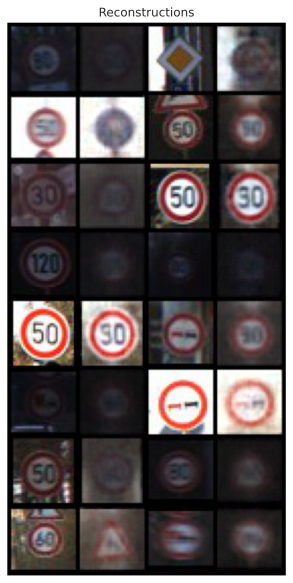

In [ ]:
input_imgs = get_train_images(16)
vae.eval()
visualize_reconstructions(vae, input_imgs, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


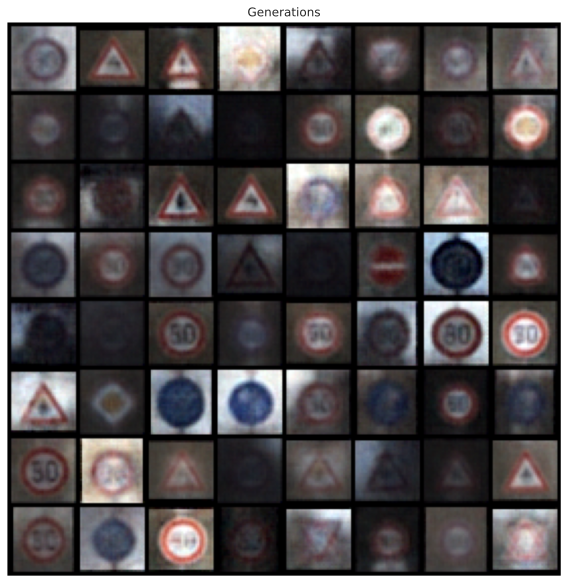

In [ ]:
vae.eval()
generate_images(vae, 64 , device)

In [ ]:
torch.save(vae,"even_better.model")

# GAN

# GLOW

# VAEGAN

https://github.com/lucabergamini/VAEGAN-PYTORCH

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.conv2 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.fc_1 = nn.Linear(128*8*8, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = F.leaky_relu(self.conv2(x) )
        x = F.leaky_relu(self.conv3(x) )
        x = F.leaky_relu(self.conv4(x) )
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(Decoder, self).__init__()

        self.conv2 = nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=3, output_padding=1, padding=1, stride=2)
        self.conv3 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, output_padding=0, padding=2, stride=1)
        self.conv4 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, output_padding=1, padding=1, stride=2)
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, 128*8*8)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 128, 8, 8])
        x_hat = F.leaky_relu(self.conv2(x_hat) )
        x_hat = F.leaky_relu(self.conv3(x_hat) )
        x_hat = F.leaky_relu(self.conv4(x_hat) )
        return x_hat

class Descriminator(nn.Module):
  pass

In [ ]:
class VaeGan(nn.Module):
  def __init__(self):
    self.encoder = Encoder(hidden_dim = 1024, latent_dim=256)
    self.decoder = Decoder(hidden_dim = 1024, latent_dim =256)
    self.discriminator = Discriminator()

# Plot Laten

In [ ]:
import umap.umap_ as umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [ ]:
def plot_latent(train_embedded, train_img_embeds, n_data=5000):
    data = pd.DataFrame(train_embedded[:n_data])
    data["label"] = train_img_embeds[2][:n_data].cpu().numpy()
    examples = []
    examples_locations = []
    for i in np.random.randint(0,n_data,40):
        examples.append(train_img_embeds[0][i].squeeze(0).cpu().numpy())
        examples_locations.append(data.iloc[i])
    fig, ax = plt.subplots(figsize=(12, 10))
    # ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
    sns.scatterplot(
        x=0, y=1,
        hue="label",
        palette=sns.color_palette("hls", 10),
        data=data,
        legend="full",
        alpha=0.1
    )
    for location, example in zip(examples_locations, examples):
        x, y = location[0], location[1]
        label = int(location["label"])
        ab = AnnotationBbox(OffsetImage(example,cmap=plt.cm.gray_r, zoom=1), (x, y), frameon=True,
                            bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
        ax.add_artist(ab)
    plt.show()

In [ ]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
            mean, var_log = model.encoder(imgs.to(device))
        img_list.append(imgs)
        embed_list.append(mean)
        labels.append(label)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0))

In [ ]:
umap_object = umap.UMAP(metric="cosine", n_neighbors=100)
train_img_embeds = embed_imgs(vae, train_loader)
# test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = umap_object.fit_transform(train_img_embeds[1][:5000].cpu())
plot_latent(train_embedded, train_img_embeds)

# Evaluator

In [ ]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [ ]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out  = nn.Linear(50, 10)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x


    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x

evaluator = Evaluator(32*32*3, 256).to(device)

In [ ]:
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)

# loss
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for data, targets in iter(train_loader):
        data, targets = data.to(device), targets.to(device)

        results = evaluator(data)
        loss = criterion(results, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
num_correct = 0
total_guesses = 0

evaluator.eval()
with torch.no_grad():
    for data, targets in iter(val_loader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = evaluator(data)
        best_guesses = torch.argmax(results, 1)

        # Updates number of correct and total guesses
        num_correct += torch.eq(targets, best_guesses).sum().item()
        total_guesses += len(targets)

print("Correctly guessed ", num_correct / total_guesses * 100, "% of the dataset")

In [ ]:
latent_dim = 16

with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim, device=device)
    generations_vae = vae.decoder(fixed_noise)
    print(generations_vae.shape)

In [ ]:
orig_data = [x[0] for x in list(val_dataset)[:1000]]
orig_data = torch.tensor(np.array(orig_data))
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()

In [ ]:
calculate_frechet_distance(dist_orig_data.numpy(),dist_vae.numpy())